# Introduction
This colab worksheet provides a starting point for Task 2 (the computer vision task).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [4]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5" -O face_alignment_training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a" -O face_alignment_test_images.npz

--2025-05-13 14:50:13--  https://sussex.box.com/shared/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5 [following]
--2025-05-13 14:50:13--  https://sussex.box.com/public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5 [following]
--2025-05-13 14:50:13--  https://sussex.app.box.com/public/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [5]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  print (checksum)
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('face_alignment_training_images.npz', 'affc56216e34c827f10681a14c602981c06ddeb3')
confirm_checksum('face_alignment_test_images.npz', 'e480535442512b8175ae110d2d3e507378cabbdb')



affc56216e34c827f10681a14c602981c06ddeb3  face_alignment_training_images.npz

e480535442512b8175ae110d2d3e507378cabbdb  face_alignment_test_images.npz



# Load the data

In [6]:
import numpy as np


# Load the data using np.load
data = np.load('face_alignment_training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('face_alignment_test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

(2811, 256, 256, 3) (2811, 5, 2)
(554, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

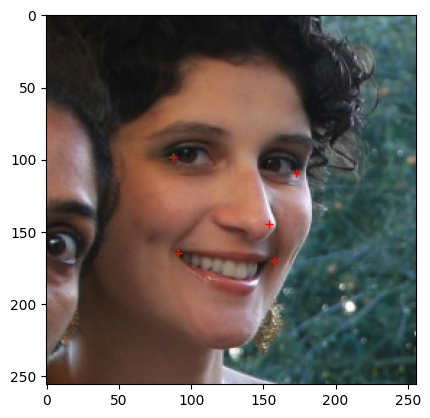

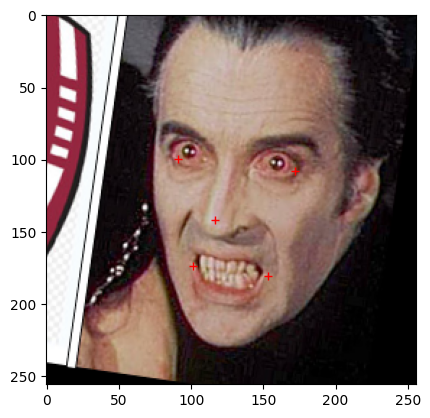

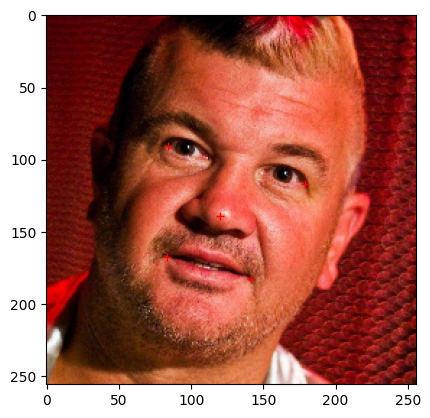

In [7]:

def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [8]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [9]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==5*2, 'wrong number of points provided. There should be 5 points with 2 values (x,y) per point'
    np.savetxt(location + '/results_task2.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


# First Model - Next Iterations Are Listed Below
# This model Uses SIFT and Ridge Regression


# SIFT and Ridge Regression
Below is the setup for facial landmark prediction using sift descriptors and ridge regression.

Overview:
- The first step was pre-processing and loading the data and test images from .npz files. Images and landmarks were resized to 80x80 scale.
- Feature extract with SIFT, descriptors are flattened, if missing zero padding used.
- Using an 80/20 split on validation data for training and testing.
- Train a ridge regression model to predict landmarks from sift features.
- Predictions and ground truths rescaled to compute Mean Point Error, per point Euclid distances, 95%tile, min / max.
- Predict landmarks for test set and save as CSV for submission.
- Plot landmarks on some random images and create histograms to analyse error.
- Failure analysis - three worst predicitons and display them for analysis.
- Compare against HOG



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



Validation Results:
Avg error: 8.768562352327894
Median error: 7.51993224980284
Best: 1.5806335356355854
Worst: 28.64271979354452


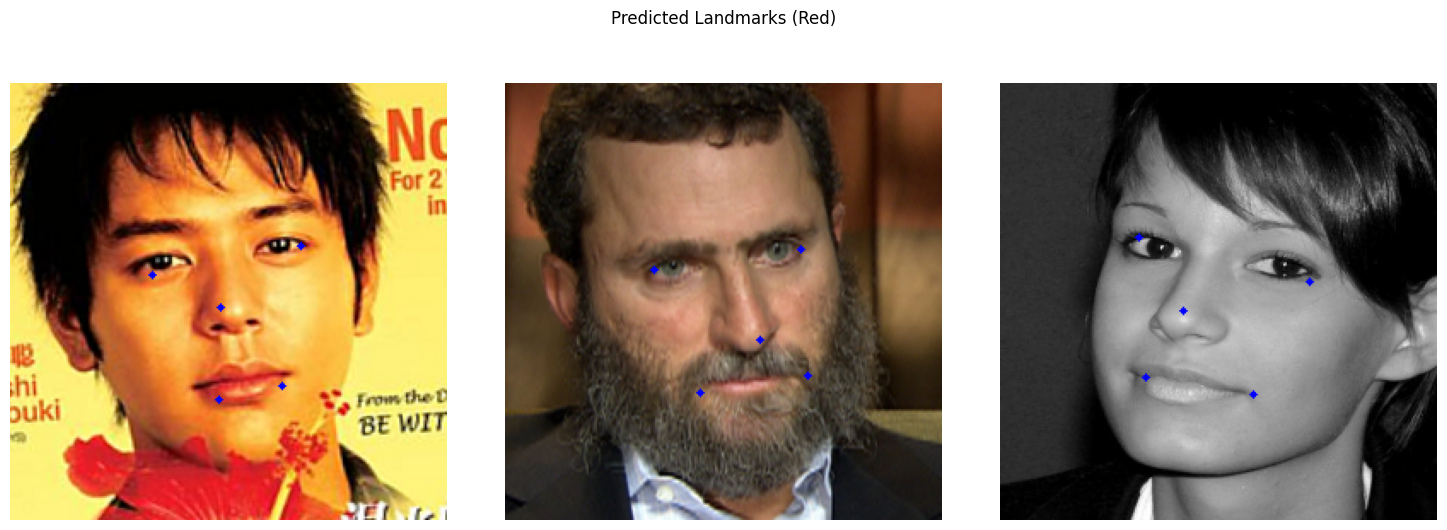

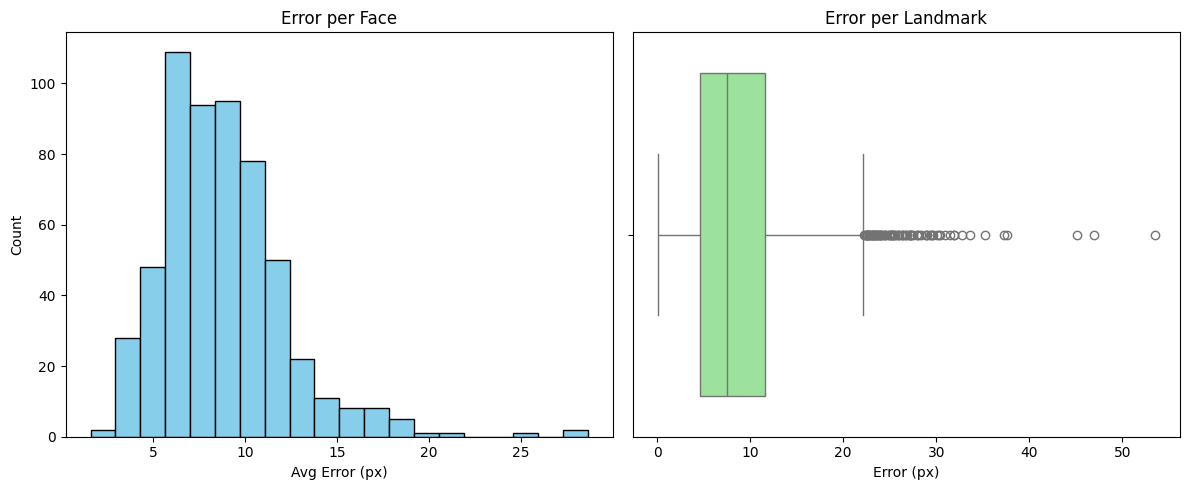

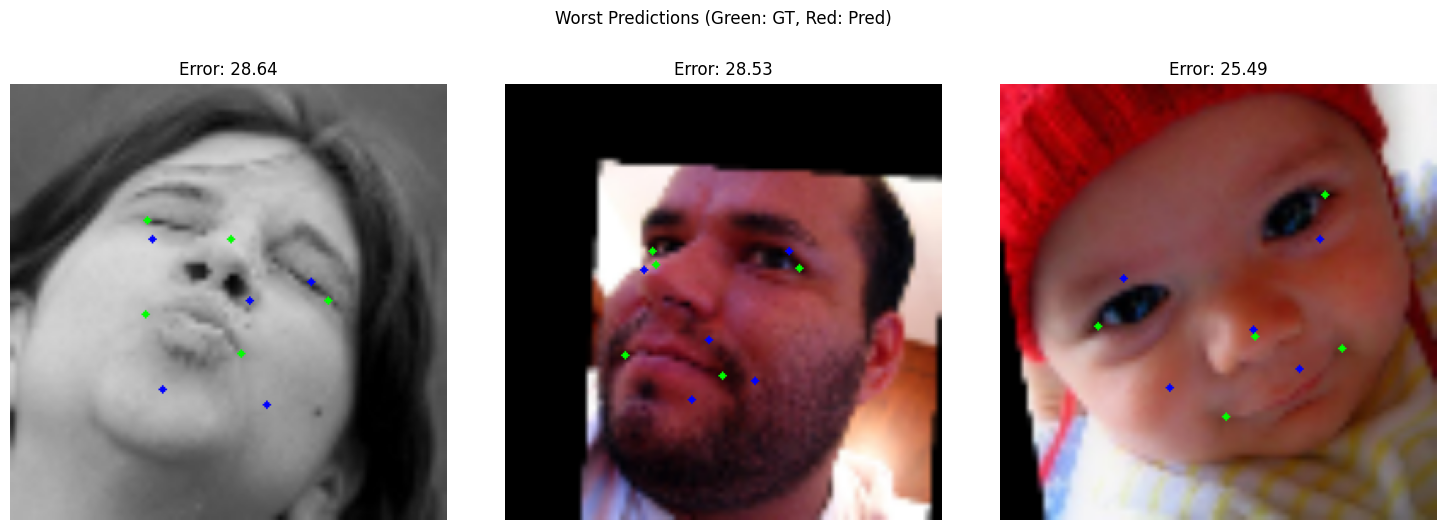

In [7]:
# SIFT and Ridge model testing
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

# Path to my data (had corrupted files from wget)
data_path = "/content/drive/MyDrive/AMLCoursework"

# Loading data
train_data = np.load(os.path.join(data_path, "face_alignment_training_images.npz"))
test_data = np.load(os.path.join(data_path, "face_alignment_test_images.npz"))

# Get the images and points
images = train_data["images"]  # pics
landmarks = train_data["points"]  # the ladnmarks
test_images = test_data["images"]  # the test pics - predictions needed after training

# Resizing imags
resized_imgs = []
resized_landmarks = []

# loop and making images smaller
for img, lm in zip(images, landmarks):
    # Resize to 80x80 - try other resizes and look at performance
    resized = cv2.resize(img, (80, 80))
    scale = 80 / img.shape[0]

    resized_imgs.append(resized)
    resized_landmarks.append(lm * scale)

resized_imgs = np.array(resized_imgs)
resized_landmarks = np.array(resized_landmarks)

# Do the same for test images
resized_test_imgs = []
for img in test_images:
    resized_test_imgs.append(cv2.resize(img, (80, 80)))
resized_test_imgs = np.array(resized_test_imgs)

# Feature extarction
sift = cv2.SIFT_create()
features = []
labels = []


for img, lm in zip(resized_imgs, resized_landmarks):
    kps = []
    for y in range(0, 80, 10):  # rows
        for x in range(0, 80, 10):  # columns
            kps.append(cv2.KeyPoint(x, y, 10))

    _, desc = sift.compute(img, kps)

    if desc is not None:
        features.append(desc.flatten())
        labels.append(lm)

X = np.array(features)
y = np.array(labels).reshape(len(labels), -1)  # flatten landmarks

# split data
# Need validation set to check if model works
idx = np.arange(len(X))
# Split 80/20 training data for training / testing
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

# Split the features and labels
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Keep some images for visualization later
val_imgs = resized_imgs[val_idx]

# Training
# Alpha=1.0 is default, play around with tuning if its better than HOG baseline
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predict on validation set
val_preds = model.predict(X_val)

n_points = val_preds.shape[1] // 2
val_preds = val_preds.reshape(-1, n_points, 2)
val_true = y_val.reshape(-1, n_points, 2)

# Scale back to original image size (256x256)
scale_back = 256 / 80
val_preds *= scale_back
val_true *= scale_back

# Calculate errors
pt_errors = np.linalg.norm(val_preds - val_true, axis=2)
face_errors = np.mean(pt_errors, axis=1)

# Print stats
print("\nValidation Results:")
print("Avg error:", np.mean(face_errors))  # mean
print("Median error:", np.median(pt_errors))  # median
print("Best:", np.min(face_errors))  # best
print("Worst:", np.max(face_errors))  # worst

# test predictions
test_feats = []
for img in resized_test_imgs:
    kps = [cv2.KeyPoint(x, y, 10) for y in range(0, 80, 10) for x in range(0, 80, 10)]
    _, desc = sift.compute(img, kps)

    if desc is not None:
        test_feats.append(desc.flatten())
    else:
        test_feats.append(np.zeros(128 * 64))

test_feats = np.array(test_feats)
test_preds = model.predict(test_feats)
test_preds = test_preds.reshape(-1, n_points, 2) * scale_back

# Save predictions to CSV
# np.savetxt(os.path.join(data_path, "face_landmark_predictions_sift.csv"),
#            test_preds.reshape(len(test_preds), -1), delimiter=",")


# Show some random test predictions, convert gray
plt.figure(figsize=(15, 5))
for i in range(3):  # 3 examples
    idx = np.random.randint(len(test_images))
    img = test_images[idx]

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for x, y in test_preds[idx]:
        cv2.circle(img, (int(x), int(y)), 2, (0, 0, 255), -1)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Predicted Landmarks (Red)", y=1.05)
plt.tight_layout()
plt.show()

# Error distribution plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(face_errors, bins=20, color='skyblue', edgecolor='black')
plt.title("Error per Face")
plt.xlabel("Avg Error (px)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(x=pt_errors.flatten(), color='lightgreen')
plt.title("Error per Landmark")
plt.xlabel("Error (px)")
plt.tight_layout()
plt.show()

# Show the worst predictions
worst = np.argsort(-face_errors)[:3]
plt.figure(figsize=(15, 5))
for i, idx in enumerate(worst):
    img = cv2.resize(val_imgs[idx], (256, 256))
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw true points = green
    for x, y in val_true[idx]:
        cv2.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)

    # Draw predict point = red
    for x, y in val_preds[idx]:
        cv2.circle(img, (int(x), int(y)), 2, (0, 0, 255), -1)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Error: {face_errors[idx]:.2f}")
    plt.axis("off")

plt.suptitle("Worst Predictions (Green: GT, Red: Pred)", y=1.05)
plt.tight_layout()
plt.show()



In [ ]:
train_data = np.load("face_alignment_training_images.npz")
print(train_data.files)
# Testing the npz files loaded correctly - had some corrupted files from the download


# Second Model: Final Model Is Third Model
# HOG Feature Extraction And Ridge Regression

# HOG and Ridge Regression
Using Histogram of Oriented Gradients (HOG) for predicting facial landmarks.

Overview:
- Training and test images loaded from .npz files.
- Rescaled to 80x80 for image and landmarks.
- HOG features are extracted from each image for local edges
- Tuned hyperparameters for lowest MPE
- Trained on 80/20 training and testing split on the training data.
- Alpha values cross validated to get best results.
- Outputs are reshaped to original so are predictions and labels for analysis and comparison
- Mean Point Error computed for all landmarks on each face.
- Mean, min, max, 95%tile computed
- Histogram, boxplot and three example images are plotted and three worst performers are visualised also.
- After training predict landmarks on unseen test set, predictions saved as CSV.




/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Best alpha picked by RidgeCV: 100.0

Validation Results:
Avg error: 5.120861967800826
Median error: 4.216525051009905
Best: 1.5663056354573677
Worst: 27.894534755922063
Saved test predictions to CSV


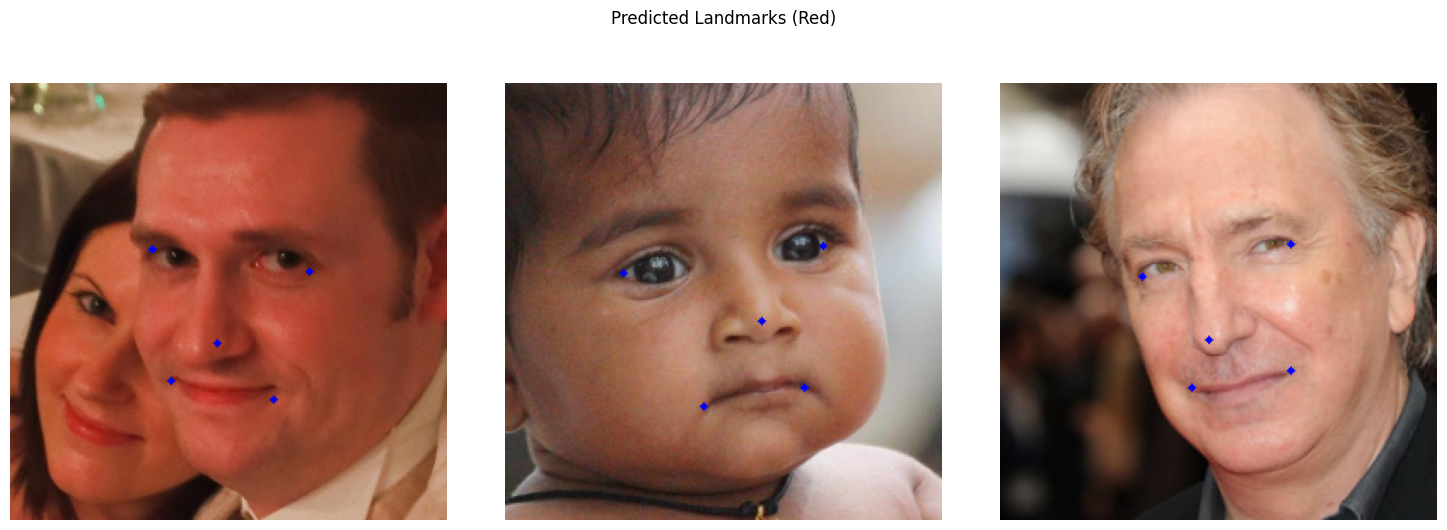

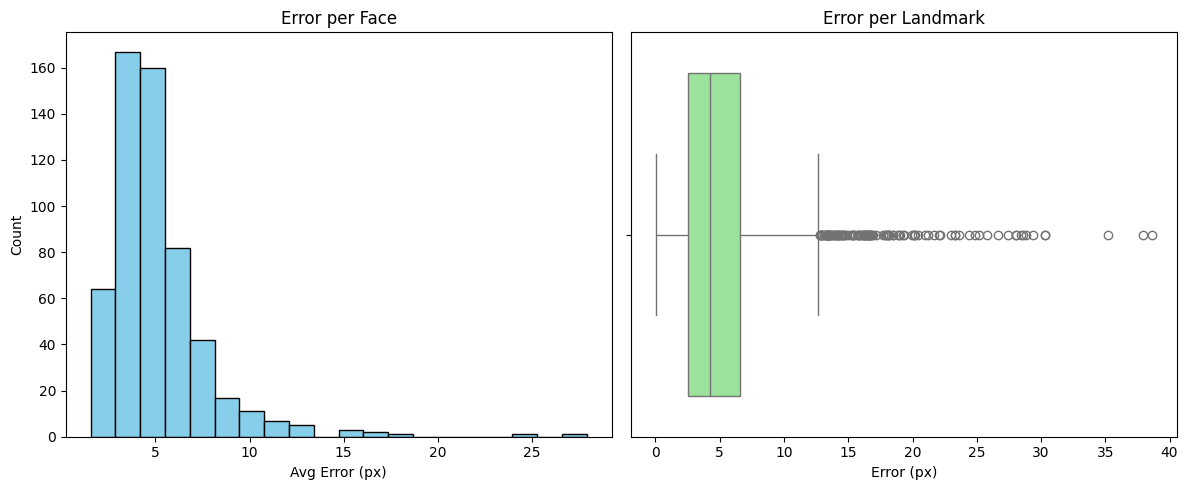

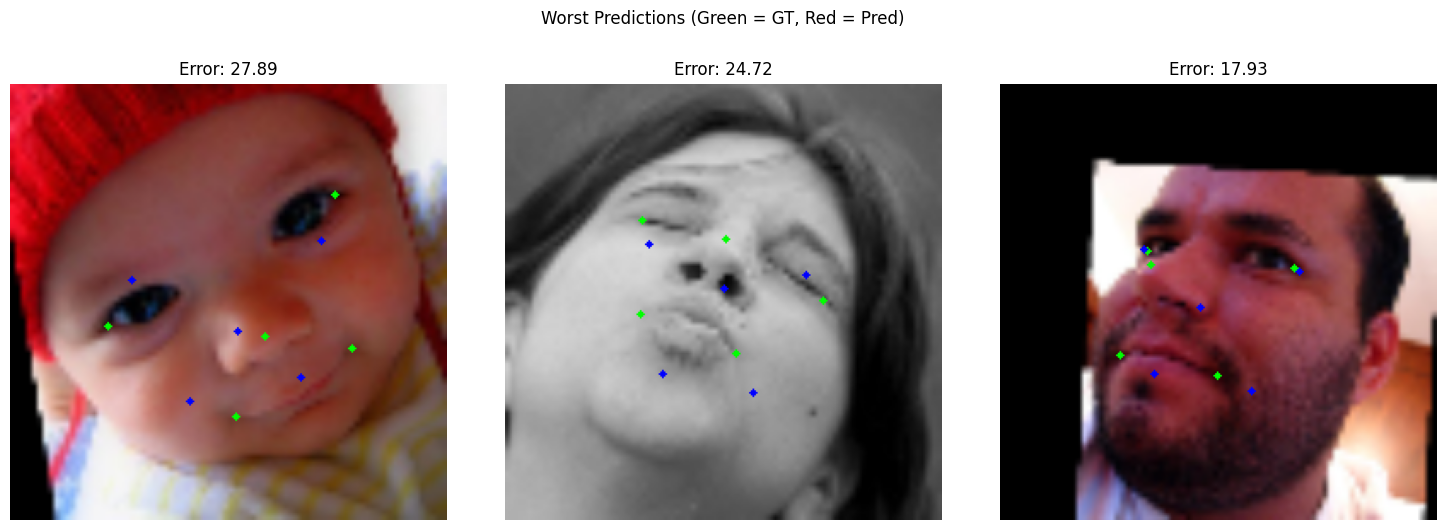

In [3]:
# HOG and Ridge Regression - closely similar to SIFT to compare the baseline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import seaborn as sns
from skimage.feature import hog
import os

# Load data
data_path = "/content/drive/MyDrive/AMLCoursework"
train_data = np.load(os.path.join(data_path, "face_alignment_training_images.npz"))
test_data = np.load(os.path.join(data_path, "face_alignment_test_images.npz"))

images = train_data["images"]
landmarks = train_data["points"]
test_images = test_data["images"]

# resize images to 80x80 same as SIFT
resized_imgs = []
resized_landmarks = []

for img, pts in zip(images, landmarks):
    resized = cv2.resize(img, (80, 80))
    scale = 80 / img.shape[0]
    resized_imgs.append(resized)
    resized_landmarks.append(pts * scale)

resized_imgs = np.array(resized_imgs)
resized_landmarks = np.array(resized_landmarks)

# resize test
resized_test_imgs = []
for img in test_images:
    resized_test_imgs.append(cv2.resize(img, (80, 80)))
resized_test_imgs = np.array(resized_test_imgs)

# get HOG features from each image
# tried a bunch of combos and this one gave best mpe (5.12)
features = []
labels = []

for img, pts in zip(resized_imgs, resized_landmarks):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feat = hog(img, pixels_per_cell=(5, 5), cells_per_block=(3, 3),
               orientations=16, block_norm='L2-Hys', feature_vector=True)
    features.append(feat)
    labels.append(pts)
# cells per block (2,2)
# orientations try 9,12,16
# Can try L1-sqrt also
# (8,8) and (2,2) = 5.83mpe
# (4,4) and (2,2) = 5.57mpe
# (4,4) and (3,3) = 5.24mpe
# (6,6) and (3,3) = 5.16mpe
# (6,6) and (2,2) = 5.41mpe
# current set up = 5.14mpe
# (5,5) and (3,3) = 5.13mpe
# 16 orientations = 5.12mpe

X = np.array(features)
y = np.array(labels).reshape(len(labels), -1)  # flatten

# split for validation - keeping indexes to check worst ones
idx = np.arange(len(X))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]
val_imgs = resized_imgs[val_idx]

# ridgecv to test multiple at once to see best fit alpha
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
model = RidgeCV(alphas=alphas, store_cv_values=True)
model.fit(X_train, y_train)
print("Best alpha picked by RidgeCV:", model.alpha_)

# validation predictions
val_preds = model.predict(X_val)
n_points = val_preds.shape[1] // 2
val_preds = val_preds.reshape(-1, n_points, 2)
val_true = y_val.reshape(-1, n_points, 2)

# scale back up to 256x256
scale_back = 256 / 80
val_preds *= scale_back
val_true *= scale_back

# error metrics
pt_errors = np.linalg.norm(val_preds - val_true, axis=2)
face_errors = np.mean(pt_errors, axis=1)

# print the stats of performance
print("\nValidation Results:")
print("Avg error:", np.mean(face_errors))
print("Median error:", np.median(pt_errors))
print("Best:", np.min(face_errors))
print("Worst:", np.max(face_errors))

# test predictions
test_feats = []
for img in resized_test_imgs:
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feat = hog(img, pixels_per_cell=(5, 5), cells_per_block=(3, 3),
               orientations=16, block_norm='L2-Hys', feature_vector=True)
    test_feats.append(feat)
test_feats = np.array(test_feats)
test_preds = model.predict(test_feats)
test_preds = test_preds.reshape(-1, n_points, 2) * scale_back

# # save it to CSV for submission
# np.savetxt(os.path.join(data_path, "face_landmark_predictions_hog.csv"),
#            test_preds.reshape(len(test_preds), -1), delimiter=",")
# print("Saved test predictions to CSV")

# image plots for analysis also
plt.figure(figsize=(15, 5))
for i in range(3):
    idx = np.random.randint(len(test_images))
    img = test_images[idx]
    pts = test_preds[idx]
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x, y in pts:
        cv2.circle(img, (int(x), int(y)), 2, (0, 0, 255), -1)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Predicted Landmarks (Red)", y=1.05)
plt.tight_layout()
plt.show()

# error plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(face_errors, bins=20, color='skyblue', edgecolor='black')
plt.title("Error per Face")
plt.xlabel("Avg Error (px)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(x=pt_errors.flatten(), color='lightgreen')
plt.title("Error per Landmark")
plt.xlabel("Error (px)")
plt.tight_layout()
plt.show()

# show worst predictions
worst = np.argsort(-face_errors)[:3]
plt.figure(figsize=(15, 5))
for i, idx in enumerate(worst):
    img = cv2.resize(val_imgs[idx], (256, 256))

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for x, y in val_true[idx]:
        cv2.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)  # GT
    for x, y in val_preds[idx]:
        cv2.circle(img, (int(x), int(y)), 2, (0, 0, 255), -1)  # prediction

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Error: {face_errors[idx]:.2f}")
    plt.axis("off")

plt.suptitle("Worst Predictions (Green = GT, Red = Pred)", y=1.05)
plt.tight_layout()
plt.show()



# Final Implementation *Submission Model*
# HOG and Ridge Regression With Data Augmentation

Using HOG and Ridge Regression based off prevous models success, adding data augmentation to provide more training and hopefully improve robustness to variation in images such as face angles or lighting.

Overview:
- Test and training images loaded from .npz files, scaled to 96x96 as exhibited best results when tuning. Landmarks are scaled accordingly - also converted to grayscale and normalised to [0,1] range
- Each image generates one augmented version either flipped horizontally or brightness / contrast tweaking alpha ∈ [0.7, 1.3] for contrast
beta ∈ [-20, +20] for brightness, increasingn size of training set.
- HOG features then extracted, then flattened into vectors for input for regression.
- 80/20 split for training and testing on validation set for model, gridsearch to find optimal regularisation strength.
- Tested and tuned alpha within the range 1-1000 then final validation predictions are rescaled for evaluation.
- Mean Point Error, min, max, 95%tile are computed.
- Random three images are visualised predictions veruss ground truths and the three worst performers are also for analysis.
- Final model retrained on test data and predictions saved as CSV for submission


Landmarks per face: 5
Doing preprocess/augmentation (original + flip/bright)
Extracting HOG features (this part is slow)
Training Ridge w/ GridSearch
Best alpha: 75
MPE on val: 4.36
95th Percentile Pointwise Error: 10.49 px
Standard Deviation of Pointwise Error: 3.23 px
Best (Minimum) Pointwise Error: 0.03 px
Worst (Maximum) Pointwise Error: 31.86 px


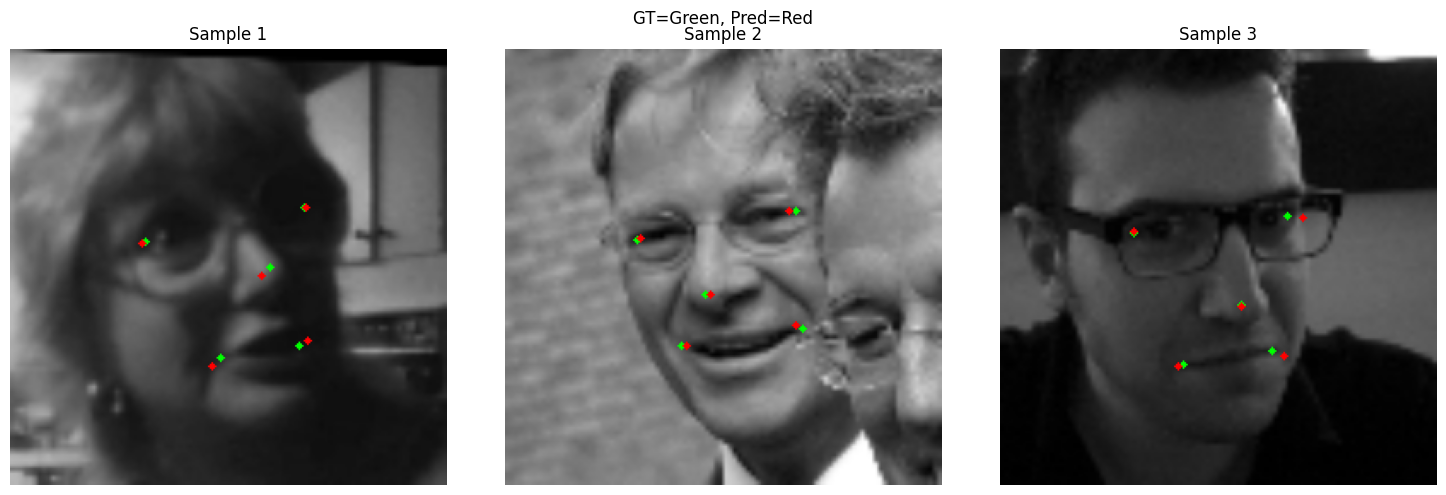

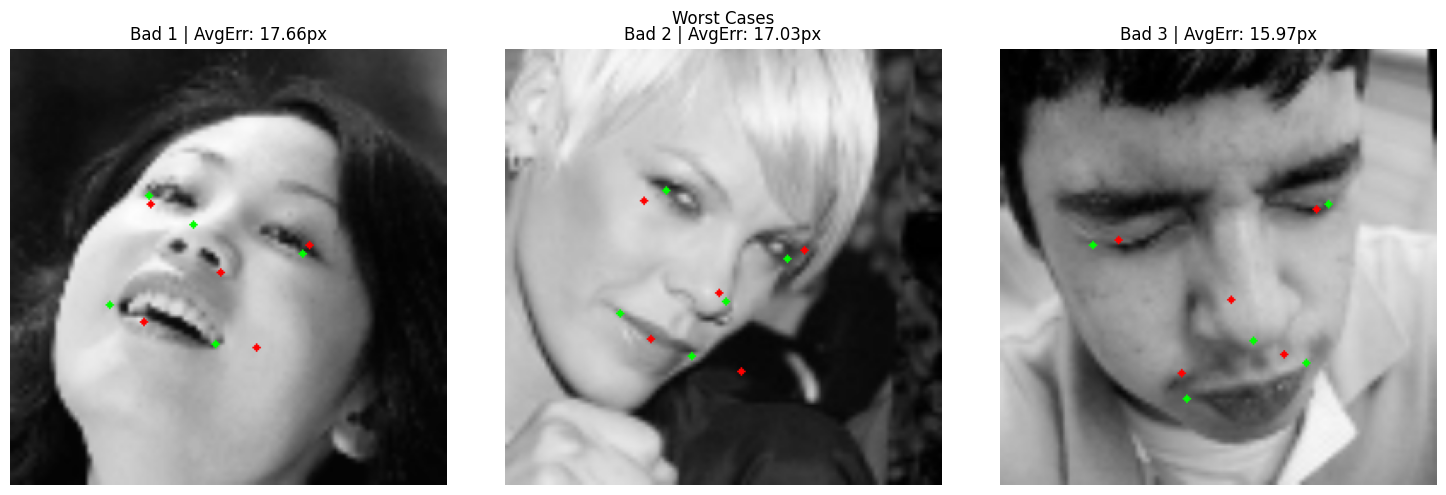

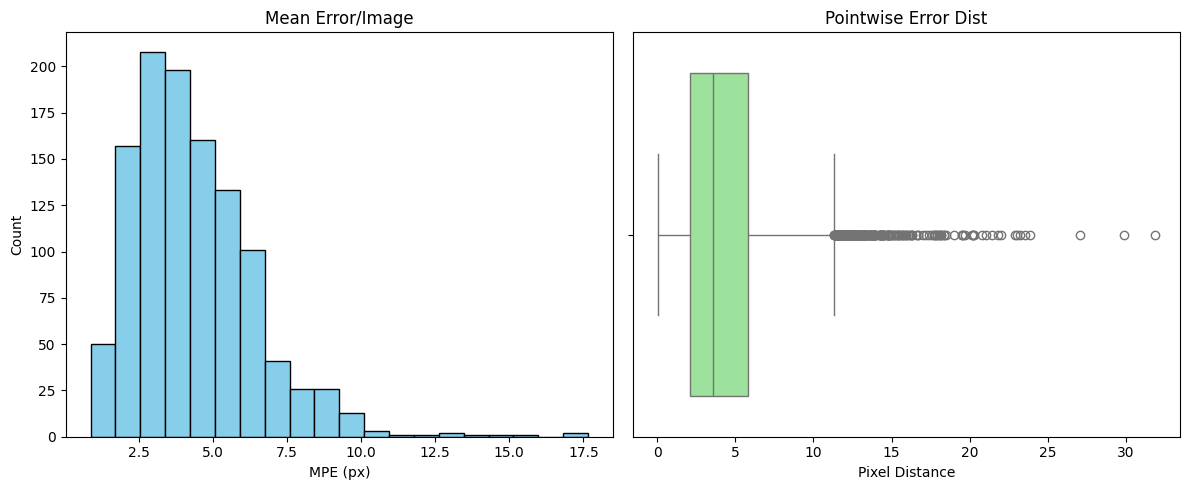

Training final model on full data
Done. Saved to results_task2.csv
Done. CSV saved.


In [3]:
# HOG and Ridge regression with data augmenting of flipping and brightness
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from skimage.feature import hog
import seaborn as sns
import random

# when flipping img - not entirely sure on this but i think it swaps left and right from research
flipping = {0: 1, 1: 0, 3: 4, 4: 3}

# 96x96 works better than 80x80 - Seemed to improve results
image_height, image_width = 96, 96
original_height, original_width = 256, 256

# image pre-processing and augmentation
def preprocess(img, pts, aug_flip=True, aug_bright=True):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # gray convert

    if aug_bright and np.random.rand() > 0.5:
        alpha = np.random.uniform(0.7, 1.3) # the contrast
        beta = np.random.randint(-20, 20) # the brightness
        img = cv2.convertScaleAbs(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), alpha=alpha, beta=beta)

    h, w = img.shape
    img = cv2.resize(img, (image_width, image_height))
    scale_x = image_width / w
    scale_y = image_height / h
    new_pts = pts.copy().astype(np.float32)
    new_pts[:, 0] *= scale_x
    new_pts[:, 1] *= scale_y # resizin images

    #horizontal flip and landmark flips
    if aug_flip and np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
        new_pts[:, 0] = (image_width - 1) - new_pts[:, 0]

        temp_pts = new_pts.copy()
        done = set()
        for a, b in flipping.items():
            key = tuple(sorted([a, b]))
            if key not in done and a < len(temp_pts) and b < len(temp_pts):
                temp = temp_pts[a].copy()
                temp_pts[a] = temp_pts[b]
                temp_pts[b] = temp
                done.add(key)
        new_pts = temp_pts

    return img.astype(np.float32)/255.0, new_pts # normalise

#test pre-processing - just resize and grayscale dont augment
def test_preproc(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (image_width, image_height))
    return img.astype(np.float32)/255.0

# Get HOG from pre-processed img
def hogify(img):
    return hog(img, orientations=9, pixels_per_cell=(5,5), cells_per_block=(3,3), block_norm='L2-Hys', transform_sqrt=True, feature_vector=True)

# load everything
base = '/content/drive/MyDrive/AMLCoursework'
train_pth = os.path.join(base, 'face_alignment_training_images.npz')
test_pth = os.path.join(base, 'face_alignment_test_images.npz')

if not os.path.exists(train_pth) or not os.path.exists(test_pth):
    print("No file found at those paths!")
    exit()

data = np.load(train_pth)
X_img_raw = data['images'] # og images
y_pts = data['points'] # og landmarks

data_test = np.load(test_pth)
X_test_raw = data_test['images'] # test imgs no labels

print("Landmarks per face:", y_pts.shape[1])

# process train data w/ aug
X_train_all = []
y_train_all = []

print("Doing preprocess/augmentation (original + flip/bright)")

np.random.seed(42)
for i in range(X_img_raw.shape[0]):
    img = X_img_raw[i]
    pts = y_pts[i]

    img1, pts1 = preprocess(img, pts, aug_flip=False, aug_bright=False) # og img
    img2, pts2 = preprocess(img, pts, aug_flip=True, aug_bright=True) # aug img
    X_train_all.append(img1)
    y_train_all.append(pts1)
    X_train_all.append(img2)
    y_train_all.append(pts2)
X_train_all = np.array(X_train_all)
y_train_all = np.array(y_train_all)

# pre-proc the test imgs
X_test_final = [test_preproc(im) for im in X_test_raw]
X_test_final = np.array(X_test_final)

print("Extracting HOG features (this part is slow)")
X_train_hog = np.array([hogify(img) for img in X_train_all])
y_train_flat = y_train_all.reshape(len(y_train_all), -1)
X_test_hog = np.array([hogify(img) for img in X_test_final])

# train-val split 80/20
X_train, X_val, y_train, y_val = train_test_split(X_train_hog, y_train_flat, test_size=0.2, random_state=42)
_, val_imgs = train_test_split(X_train_all, test_size=0.2, random_state=42)

# train ridge using gridsearch
print("Training Ridge w/ GridSearch")
param_grid = {'alpha': [1,25,50,75,100,125,150]}
ridge = Ridge(random_state=42)
gs = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
print("Best alpha:", best_model.alpha)
# landmark predict on the test set
preds_val = best_model.predict(X_val)

# evaluate the performance overll
scale = original_height / image_height # resize to 256x256
gt_pts = y_val.reshape(-1, y_pts.shape[1], 2)
pred_pts = preds_val.reshape(-1, y_pts.shape[1], 2)
gt_pts_scaled = gt_pts * scale
pred_pts_scaled = pred_pts * scale
err = np.linalg.norm(pred_pts_scaled - gt_pts_scaled, axis=2) # euclid
mpe = np.mean(err) # MPE
print("MPE on val:", round(mpe, 2))
p95 = np.percentile(err, 95) # 95%tile
print(f"95th Percentile Pointwise Error: {p95:.2f} px")
std_err = np.std(err) #std
min_err = np.min(err) # min
max_err = np.max(err) # max
print(f"Standard Deviation of Pointwise Error: {std_err:.2f} px")
print(f"Best (Minimum) Pointwise Error: {min_err:.2f} px")
print(f"Worst (Maximum) Pointwise Error: {max_err:.2f} px")
# stats for report analysis


# plot the random images predictions veruss GT
plt.figure(figsize=(15,5))
for i in range(3):
    ix = np.random.randint(0, len(val_imgs))
    img = (val_imgs[ix] * 255).astype(np.uint8)
    img = cv2.resize(img, (original_width, original_height))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for (x,y) in gt_pts_scaled[ix]:
        cv2.circle(img, (int(x), int(y)), 2, (0,255,0), -1)
    for (x,y) in pred_pts_scaled[ix]:
        cv2.circle(img, (int(x), int(y)), 2, (255,0,0), -1)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Sample {i+1}")
plt.suptitle("GT=Green, Pred=Red")
plt.tight_layout()
plt.show()

# plot the 3 worst ones for report analysis
bad_idxs = np.argsort(-np.mean(err, axis=1))[:3]
plt.figure(figsize=(15,5))
for i, ix in enumerate(bad_idxs):
    img = (val_imgs[ix] * 255).astype(np.uint8)
    img = cv2.resize(img, (original_width, original_height))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for (x,y) in gt_pts_scaled[ix]:
        cv2.circle(img, (int(x), int(y)), 2, (0,255,0), -1)
    for (x,y) in pred_pts_scaled[ix]:
        cv2.circle(img, (int(x), int(y)), 2, (255,0,0), -1)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"Bad {i+1} | AvgErr: {np.mean(err[ix]):.2f}px")
    plt.axis("off")
plt.suptitle("Worst Cases")
plt.tight_layout()
plt.show()

# plot error histo
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.mean(err, axis=1), bins=20, color='skyblue', edgecolor='black')
plt.title("Mean Error/Image")
plt.xlabel("MPE (px)")
plt.ylabel("Count")

# euclid boxplot
plt.subplot(1,2,2)
sns.boxplot(x=err.flatten(), color='lightgreen')
plt.title("Pointwise Error Dist")
plt.xlabel("Pixel Distance")
plt.tight_layout()
plt.show()

# retrain + predict
print("Training final model on full data")
final_model = Ridge(alpha=best_model.alpha, random_state=42)
final_model.fit(X_train_hog, y_train_flat)

test_pred = final_model.predict(X_test_hog)
test_pts = test_pred.reshape(-1, y_pts.shape[1], 2) * scale

# ensure same shape as the csv function provided
assert test_pts.shape[0] == 554, 'wrong number of image points, should be 554 test images'
assert np.prod(test_pts.shape[1:]) == 5*2, 'wrong number of points. Should be 5 points with 2 values (x,y) each'

# Save in the required format
np.savetxt(os.path.join(base, "results_task2.csv"), test_pts.reshape(test_pts.shape[0], -1), delimiter=',')
print("Done. Saved to results_task2.csv")
print("Done. CSV saved.")
